##Dataset Schema Design

Column	Type	Description

return_id	-> string	-> Unique return identifier

customer_lat -> float	-> Latitude of customer return location

customer_lon	-> float	-> Longitude of customer return location

product_category	-> string	-> Category (e.g., Electronics, Apparel)

product_weight	-> float	-> Weight in kg

return_reason	-> string	-> Reason (e.g., Defective, Wrong Item)

warehouse_id	-> string	-> Assigned warehouse hub (optional initially)

We’ll simulate:

1,000 return requests

5 warehouse hubs

5 product categories

Return reasons: "Defective", "Size Issue", "Changed Mind", etc.

##Generate the Dataset

In [18]:
import pandas as pd
import numpy as np
import random

#define constraints
NUM_RETURNS = 1000
WAREHOUSE_LOCATIONS = {
    'WH1': (28.7041, 77.1025),  # Delhi
    'WH2': (19.0760, 72.8777),  # Mumbai
    'WH3': (12.9716, 77.5946),  # Bangalore
    'WH4': (22.5726, 88.3639),  # Kolkata
    'WH5': (13.0827, 80.2707),  # Chennai
}

CATEGORIES = ['Electronics', 'Apparel', 'Home', 'Beauty', 'Books']

REASONS = ['Defective', 'Wrong Item', 'Changed Mind', 'Size Issue', 'Other']

#generate data
np.random.seed(42)

data = {
    'return_id': [f'R{i:04d}' for i in range(NUM_RETURNS)],
    'customer_lat': np.random.uniform(8.0, 37.0, NUM_RETURNS),
    'customer_lon': np.random.uniform(68.0, 97.0, NUM_RETURNS),
    'product_category': np.random.choice(CATEGORIES, NUM_RETURNS),
    'product_weight': np.round(np.random.uniform(0.2, 5.0, NUM_RETURNS), 2),
    'return_reason': np.random.choice(REASONS, NUM_RETURNS),
    'warehouse_id': np.random.choice(list(WAREHOUSE_LOCATIONS.keys()), NUM_RETURNS)
}

df_returns = pd.DataFrame(data)

In [19]:
df_returns.head()

,return_id,customer_lat,customer_lon,product_category,product_weight,return_reason,warehouse_id
0,R0000,18.861663,73.368855,Beauty,3.36,Wrong Item,WH1
1,R0001,35.570715,83.715127,Home,0.72,Other,WH5
2,R0002,29.227824,93.315429,Beauty,3.26,Other,WH2
3,R0003,25.361096,89.234522,Apparel,2.59,Other,WH4
4,R0004,12.524541,91.390273,Apparel,2.15,Changed Mind,WH2


##Clustering Returns Based on Location (KMeans)

Goal:

Group return locations into geographic clusters so we can:

Route returns more efficiently

Assign them to nearest warehouses or pickup zones



Why Clustering?

Clustering helps us:

Group geographically close returns

Reduce cost by consolidating pickups

Feed clusters into Vehicle Routing Problem (VRP) in the next step



In [20]:
#extract latitude and logitude of customer locations
location_data = df_returns[['customer_lat' , 'customer_lon']]

In [21]:
from sklearn.preprocessing import StandardScaler

#normalize the data to have mean = 0 and std = 1
scaler = StandardScaler()
scaled_location = scaler.fit_transform(location_data)

In [22]:
from sklearn.cluster import KMeans

#define number of clusters
k=4
kmeans = KMeans(n_clusters=k , random_state=42)
df_returns['cluster_id'] = kmeans.fit_predict(scaled_location)

In [23]:
# Get centroids (depot location per cluster)
centroids = kmeans.cluster_centers_


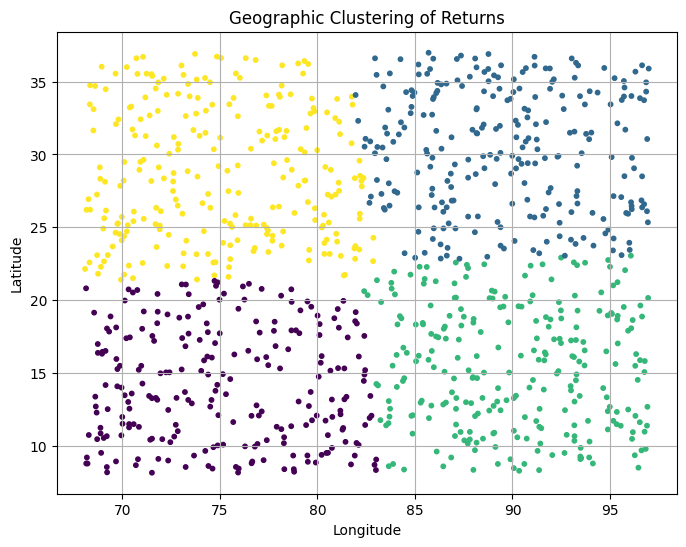

In [24]:
import matplotlib.pyplot as plt

#scatter plot of return locations colored by cluster
plt.figure(figsize=(8,6))
plt.scatter(df_returns['customer_lon'], df_returns['customer_lat'] , c=df_returns['cluster_id'] , cmap='viridis' , s=10)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographic Clustering of Returns')
plt.grid(True)
plt.show()

Returns in the same cluster are geographically close and can be grouped for pickup routing.

You can assign one warehouse or return center per cluster.

This enables:

Lower fuel costs

Fewer return trucks covering overlapping areas

Better route planning for reverse logistics

Scalability for nationwide return management

📊 Insights From Your Plot

Color Zone	Interpretation

🟣 (Bottom-left)	Covers western-southern areas (likely states like Maharashtra, Gujarat, etc.)

🟢 (Top-left)	Northern-central cluster (possibly Rajasthan, Delhi, Punjab)

🔵 (Top-right)	Eastern-northern cluster (e.g., Bihar, West Bengal)

🟡 (Bottom-right)	South-eastern region (Tamil Nadu, Andhra Pradesh, etc.)

🟦 (Center-south)	Central belt — bridging between clusters, ideal for a central hub

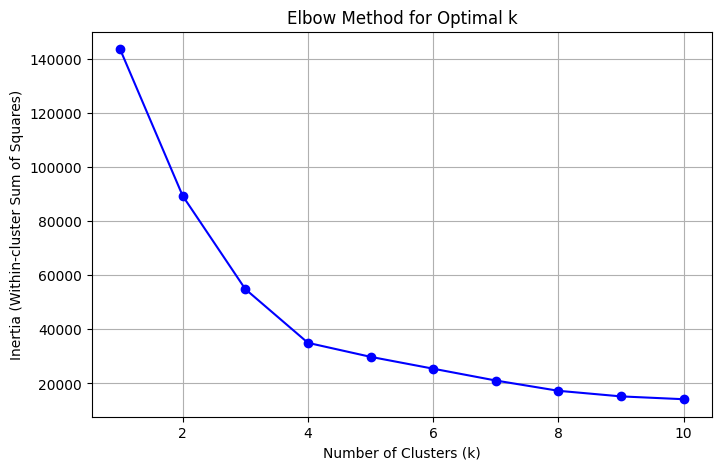

In [25]:
#elbow methdod for better optimization of k value

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# Extract coordinates
coords = df_returns[['customer_lon', 'customer_lat']]

# Range of k values to test
k_values = range(1, 11)
inertias = []

# Run KMeans for each k and collect inertia
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(coords)
    inertias.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-cluster Sum of Squares)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()


What This Means

With k=4, the returns are grouped into 4 geographically cohesive clusters.

This helps optimize the reverse logistics process by minimizing return center distances and grouping returns efficiently.

##Route Optimization Using Nearest Neighbor Heuristic

🔧 What We’ll Do

Pick one cluster (say, Cluster 0 from k=4).

Simulate depot (can be at the centroid of that cluster).

Apply Nearest Neighbor Algorithm to plan pickup route.

Visualize the route (in 2D space).

###Route Optimization with Nearest Neighbor (for Cluster 0)

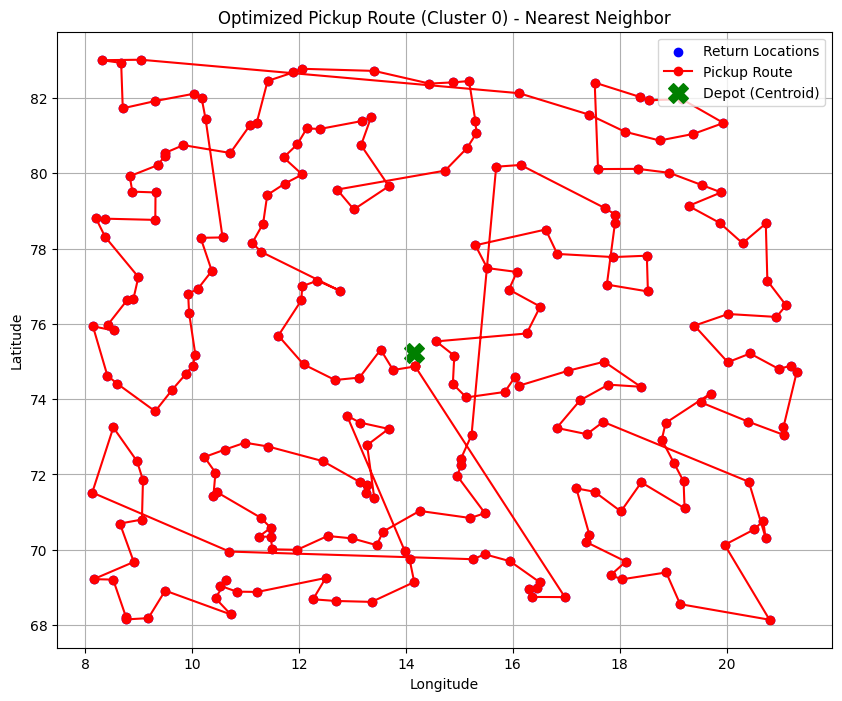

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

# Assuming df is your dataframe with 'Latitude' and 'Longitude' already created
# and cluster labels are in df['Cluster']

# Filter for Cluster 0
cluster_df = df_returns[df_returns['cluster_id'] == 0].reset_index(drop=True)

# Convert coordinates to NumPy array
locations = cluster_df[['customer_lon', 'customer_lat']].values

# Set the depot as the centroid of the cluster
depot = locations.mean(axis=0)

# Nearest Neighbor Algorithm
def nearest_neighbor_route(start, locations):
    visited = [start]
    current = start
    remaining = list(range(len(locations)))
    route = []

    while remaining:
        distances = cdist([locations[current]], locations[remaining], metric='euclidean')[0]
        nearest_idx = remaining[np.argmin(distances)]
        route.append(nearest_idx)
        visited.append(nearest_idx)
        current = nearest_idx
        remaining.remove(nearest_idx)

    return route

# Start at nearest location to depot
start_idx = np.argmin(cdist([depot], locations)[0])
route = nearest_neighbor_route(start_idx, locations)

# Add depot at the beginning and end
full_route = [start_idx] + route + [start_idx]

# Plotting the route
plt.figure(figsize=(10, 8))
plt.scatter(locations[:, 1], locations[:, 0], c='blue', label='Return Locations')
plt.plot(locations[full_route, 1], locations[full_route, 0], '-o', c='red', label='Pickup Route')
plt.scatter(depot[1], depot[0], c='green', marker='X', s=200, label='Depot (Centroid)')
plt.title("Optimized Pickup Route (Cluster 0) - Nearest Neighbor")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.show()


#Cost Estimation & Optimization


In [27]:
# Define constants for cost model
COST_PER_KM = 0.5           # Cost per kilometer for transport (fuel, driver, wear & tear)
COST_PER_RETURN = 2.0       # Handling cost per return item (sorting, inspection, restocking)
WAREHOUSE_DAILY_COST = 100  # Fixed cost to operate a depot/warehouse per day


🌍 What is the Haversine Formula?

The Haversine formula calculates the shortest distance over the Earth's surface between two points (i.e., as the crow flies), given their latitude and longitude.

It's useful for:

GPS tracking

Distance calculations in mapping apps

Flight distances

Geo-fencing

It accounts for the curvature of the Earth, which is approximately a sphere, not a flat plane.

In [28]:
from math import radians, sin, cos, sqrt, atan2

def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the great-circle distance between two geo-points using the Haversine formula.
    Returns distance in kilometers.
    """
    R = 6371.0  # Earth's radius in kilometers

    # Convert coordinates from degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1 #difference in latitude(in radians)
    dlon = lon2 - lon1 #difference in longitude (in radians)

    # Haversine formula
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2

    #This gives the square of half the chord length between the
    #points on the sphere.


    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    #This computes the angular distance between the two points in radians.
    #c is the angle (in radians) between the two points at the center of the Earth.


    return R * c
    #Multiplies the angular distance (c) by the Earth's radius (R) to get the distance in kilometers.

This accurately calculates real-world distance for cost estimation over geographic coordinates (latitude, longitude).

In [29]:
#Cost Function for Each Cluster

def calculate_cluster_cost(cluster_df, depot_coord):
    """
    Estimate the total cost for handling returns in a given cluster.
    Includes transportation, handling, and warehouse costs.
    """
    from sklearn.neighbors import NearestNeighbors

    # Prepare coordinates
    coords = cluster_df[['Latitude', 'Longitude']].values
    visited = [False] * len(coords)
    route_order = []

    # Start from depot and find nearest neighbor sequence
    current_index = -1
    current_point = depot_coord

    for _ in range(len(coords)):
        # Find nearest unvisited point
        min_dist = float('inf')
        nearest_idx = -1
        for idx, (lat, lon) in enumerate(coords):
            if not visited[idx]:
                dist = haversine_distance(current_point[0], current_point[1], lat, lon)
                if dist < min_dist:
                    min_dist = dist
                    nearest_idx = idx
        visited[nearest_idx] = True
        route_order.append(coords[nearest_idx])
        current_point = coords[nearest_idx]

    # Return to depot at end
    total_distance = 0
    current_point = depot_coord
    for point in route_order:
        total_distance += haversine_distance(current_point[0], current_point[1], point[0], point[1])
        current_point = point
    total_distance += haversine_distance(current_point[0], current_point[1], depot_coord[0], depot_coord[1])

    # Cost breakdown
    transport_cost = total_distance * COST_PER_KM
    handling_cost = len(coords) * COST_PER_RETURN
    total_cost = transport_cost + handling_cost + WAREHOUSE_DAILY_COST

    return {
        'Num Returns': len(coords),
        'Total Distance (km)': round(total_distance, 2),
        'Transport Cost': round(transport_cost, 2),
        'Handling Cost': round(handling_cost, 2),
        'Warehouse Cost': WAREHOUSE_DAILY_COST,
        'Total Cost': round(total_cost, 2)
    }


In [35]:
# Rename the columns to standard 'Latitude' and 'Longitude'
df_returns.rename(columns={
    'customer_lat': 'Latitude',
    'customer_lon': 'Longitude'
}, inplace=True)


In [36]:
import pandas as pd

# DataFrame to hold cost summaries
cost_summary = []

# Loop through all cluster labels from previous KMeans step
for cluster_id in sorted(df_returns['cluster_id'].unique()):
    cluster_df = df_returns[df_returns['cluster_id'] == cluster_id]
    depot_coord = centroids[cluster_id]  # From previous KMeans result
    result = calculate_cluster_cost(cluster_df, depot_coord)
    result['Cluster'] = cluster_id
    cost_summary.append(result)

# Convert to DataFrame
cost_df = pd.DataFrame(cost_summary)
cost_df = cost_df[['Cluster', 'Num Returns', 'Total Distance (km)',
                   'Transport Cost', 'Handling Cost',
                   'Warehouse Cost', 'Total Cost']]
cost_df


,Cluster,Num Returns,Total Distance (km),Transport Cost,Handling Cost,Warehouse Cost,Total Cost
0,0,235,37415.76,18707.88,470.0,100,19277.88
1,1,254,39859.81,19929.90,508.0,100,20537.90
2,2,259,44217.71,22108.85,518.0,100,22726.85
3,3,252,39597.77,19798.89,504.0,100,20402.89


🔍 Key Observations

Cluster 2 is the most expensive:

Highest transport cost (44217.71 km, ₹22108.85)

Highest number of returns (259)

Indicates it's geographically more spread or farther from the depot

Cluster 0 is the cheapest:

Fewer returns (235)

Lowest total transport cost

Warehouse cost is fixed:

You've used a constant value of ₹100 per cluster (can be refined if needed)